In [1]:
!pip install kaggle --quiet

In [2]:
!kaggle datasets download ravitejauoh/cookie --quiet

Dataset URL: https://www.kaggle.com/datasets/ravitejauoh/cookie
License(s): unknown


In [3]:
!unzip -q cookie.zip

In [4]:
#flatten the dataset
import os
import shutil

source_dir = "/content/kaggledataset"
destination_dir = "/content/flattened_cookie"

os.makedirs(destination_dir, exist_ok=True)


for root, _, files in os.walk(source_dir):
    for file in files:
        source_path = os.path.join(root, file)
        destination_path = os.path.join(destination_dir, file)
        shutil.move(source_path, destination_path)

print(f"Files flattened from '{source_dir}' to '{destination_dir}'")


Files flattened from '/content/kaggledataset' to '/content/flattened_cookie'


## Gotta check the size of the images

In [5]:
import os
from PIL import Image

dataset_dir = "/content/flattened_cookie"

image_sizes = {}

for filename in os.listdir(dataset_dir):
    if filename.endswith(('.jpg')):
        filepath = os.path.join(dataset_dir, filename)
        try:
            with Image.open(filepath) as img:
                width, height = img.size
                size_tuple = (width, height)
                if size_tuple in image_sizes:
                    image_sizes[size_tuple] +=1
                else:
                    image_sizes[size_tuple] = 1
        except Exception as e:
            print(f"Error processing image {filename}: {e}")


for size, count in image_sizes.items():
    print(f"Size {size}: {count} images")

Size (700, 645): 911 images


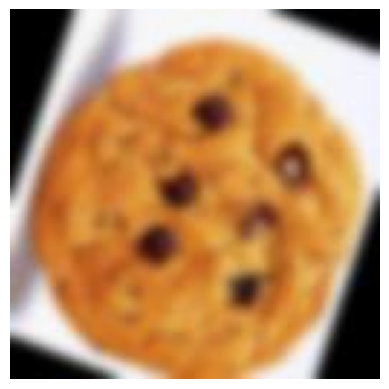

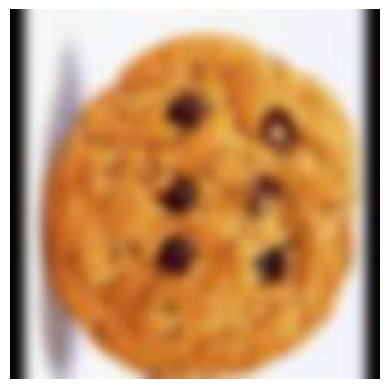

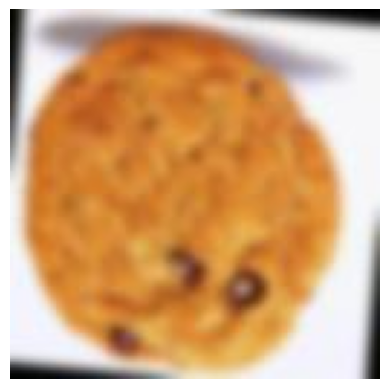

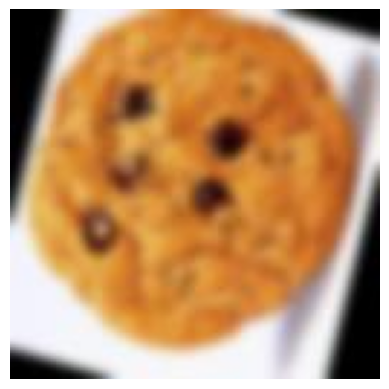

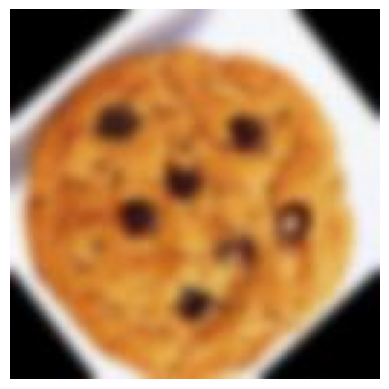

In [6]:
# prompt: resize the image to 128x128 and display some of them. make it blurry

import os
from PIL import Image, ImageFilter

# Define the target size and blur radius
target_size = (128, 128)
blur_radius = 2

# Specify the directory containing the images
dataset_dir = "/content/flattened_cookie"

# Create a directory to store the resized and blurred images
output_dir = "/content/resized_blurred_images"
os.makedirs(output_dir, exist_ok=True)

# Iterate through the images in the directory
image_count = 0
for filename in os.listdir(dataset_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add more extensions if needed
        filepath = os.path.join(dataset_dir, filename)
        try:
            with Image.open(filepath) as img:
                # Resize the image
                resized_img = img.resize(target_size)

                # Apply Gaussian blur
                blurred_img = resized_img.filter(ImageFilter.GaussianBlur(radius=blur_radius))

                # Save the resized and blurred image to the output directory
                output_path = os.path.join(output_dir, filename)
                blurred_img.save(output_path)

                image_count +=1

        except Exception as e:
            print(f"Error processing image {filename}: {e}")

# Display the first 5 resized and blurred images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(5):
  image_path = os.path.join(output_dir, os.listdir(output_dir)[i]) # get the first 5 images
  img = mpimg.imread(image_path)
  plt.imshow(img)
  plt.axis('off') #hide axis
  plt.show()

In [7]:
# Create a directory to store the grayscale images
grayscale_dir = "/content/grayscale_images"
os.makedirs(grayscale_dir, exist_ok=True)

# Iterate through the resized and blurred images
for filename in os.listdir(output_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        filepath = os.path.join(output_dir, filename)
        try:
            with Image.open(filepath) as img:
                # Convert the image to grayscale
                grayscale_img = img.convert("L")

                # Save the grayscale image to the output directory
                output_path = os.path.join(grayscale_dir, filename)
                grayscale_img.save(output_path)

        except Exception as e:
            print(f"Error processing image {filename}: {e}")

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ColorAutoencoder(nn.Module):
    def __init__(self):
        super(ColorAutoencoder, self).__init__()

        # Encoder for grayscale image
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),   # Output: 32 x H/2 x W/2
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout with a probability of 20%

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 64 x H/4 x W/4
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout with a probability of 30%

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: 128 x H/8 x W/8
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.4),  # Dropout with a probability of 40%

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),  # Smaller latent space for reduced complexity
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout with a probability of 50%
        )

        # Decoder to reconstruct the color image
        self.decoder = nn.Sequential(
            nn.Linear(512, 128 * 16 * 16),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout with a probability of 50%
            nn.Unflatten(1, (128, 16, 16)),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 64 x H/4 x W/4
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.4),  # Dropout with a probability of 40%

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # Output: 32 x H/2 x W/2
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout with a probability of 30%

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),     # Output: 3 x H x W (RGB)
            nn.Sigmoid(),  # Output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [19]:
# Custom dataset to load grayscale and color images with the same name
class GrayscaleColorDataset(torch.utils.data.Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None):
        self.grayscale_dir = grayscale_dir
        self.color_dir = color_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(grayscale_dir))
        self.image_names = [name for name in self.image_names if name.endswith(".jpg")]  # Filter for .png files

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        grayscale_image_name = self.image_names[idx]
        color_image_name = grayscale_image_name  # Same name, different folder

        grayscale_image = Image.open(os.path.join(self.grayscale_dir, grayscale_image_name)).convert('L')
        color_image = Image.open(os.path.join(self.color_dir, color_image_name))

        if self.transform:
            grayscale_image = self.transform(grayscale_image)
            color_image = self.transform(color_image)

        return grayscale_image, color_image

Number of images in the dataset: 911
Epoch [1/5], Loss: 0.1272
Epoch [2/5], Loss: 0.0804
Epoch [3/5], Loss: 0.0510
Epoch [4/5], Loss: 0.0336
Epoch [5/5], Loss: 0.0246
Average Test Loss: 0.0091


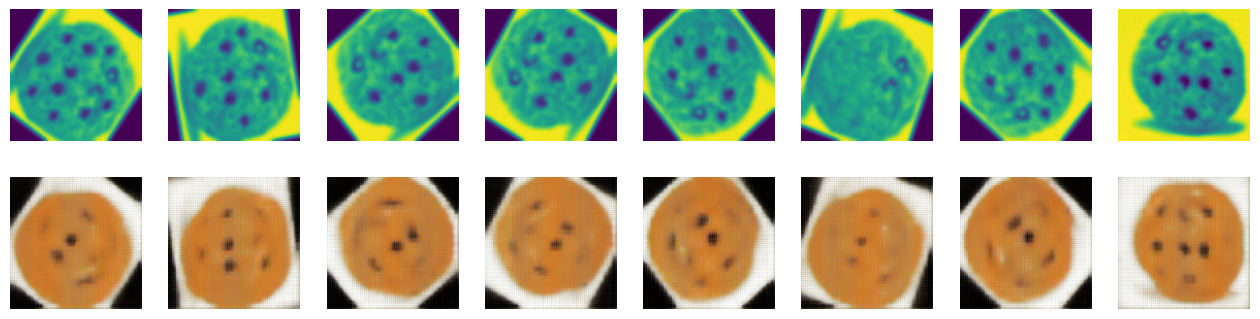

Training finished.


In [40]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Initialize the dataset with grayscale and color images
grayscale_dir = '/content/grayscale_images'
color_dir = '/content/resized_blurred_images'

dataset = GrayscaleColorDataset(grayscale_dir, color_dir, transform=transform)

print(f"Number of images in the dataset: {len(dataset)}")
# Split data into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
color_model = ColorAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(color_model.parameters(), lr=0.001, weight_decay=1e-5)

# L1 regularization parameter
l1_lambda = 1e-7

# Training loop for the color autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    color_model.train()
    running_loss = 0.0
    for grayscale_img, color_img in train_loader:
        grayscale_img = grayscale_img.to(device)
        color_img = color_img.to(device)

        # Pass grayscale image into the color autoencoder
        output = color_model(grayscale_img)

        # The target is the original color image
        reconstruction_loss = criterion(output, color_img)

        # L1 regularization
        l1_loss = sum(torch.sum(torch.abs(param)) for param in color_model.parameters())
        total_loss = reconstruction_loss + l1_lambda * l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Evaluation and Visualization
color_model.eval()  # Set to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for grayscale_img, color_img in test_loader:
        grayscale_img = grayscale_img.to(device)
        color_img = color_img.to(device)

        # Pass through the color autoencoder
        output = color_model(grayscale_img)

        # Calculate loss
        loss = criterion(output, color_img)
        test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f'Average Test Loss: {avg_test_loss:.4f}')

    # Visualize original vs. reconstructed color images
    batch_data, _ = next(iter(test_loader))
    batch_data = batch_data.to(device)

    reconstructed_batch = color_model(batch_data)

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(batch_data[i].cpu().numpy().transpose(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_batch[i].cpu().numpy().transpose(1, 2, 0))
        axes[1, i].axis('off')

    plt.show()

print("Training finished.")


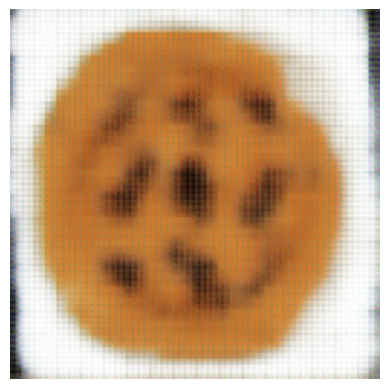

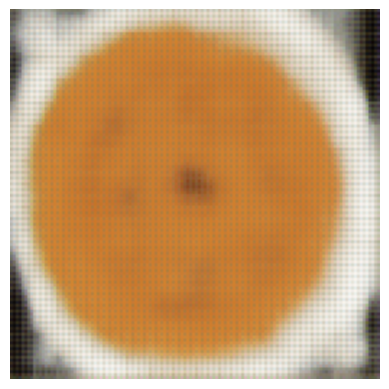

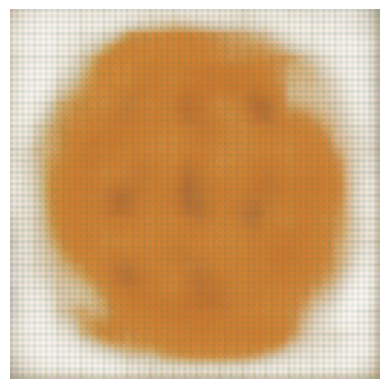

In [41]:
def process_image(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        img = img.resize((128, 128))  # Resize

        # Grayscale conversion
        grayscale_img = img.convert("L")
        grayscale_img_tensor = transforms.ToTensor()(grayscale_img).unsqueeze(0).to(device)

        # Color autoencoder
        with torch.no_grad():
            color_output = color_model(grayscale_img_tensor)

        # Convert to PIL Image and save or display
        color_output = color_output.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        color_output = (color_output * 255).astype("uint8")
        color_output_image = Image.fromarray(color_output)

        return color_output_image

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

for img_path in ['car_wheel.jpg','america.png','pizza.png']:
  processed_image = process_image(img_path)

  if processed_image:
      processed_image.save(f"output_{img_path}") # Save the processed image
      plt.imshow(processed_image)
      plt.axis('off')
      plt.show()

In [42]:
torch.save(color_model.state_dict(), 'color_autoencoder.pth')